# Zero-shot reference mapping tutorial with scGPT

## Introduction

This tutorial covers the zero-shot reference mapping with scGPT. This workflow achieves accurate and fast reference mapping for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT. To further boost the performance, we recommend fine-tuning scGPT.

Particularly, we use the `scGPT_human` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y). 


The zero-shot reference mapping workflow is as follows:

 1. Load and pre-process the dataset
    
 2. Load scGPT embeddings for each cell in reference and embed query datasets

 3. Transfer the annotations from reference to query dataset

We use a similarity-based method for transferring the annotation, which involves comparing the similarity between the query cell embedding and the reference cell embeddings. We use [FAISS](https://github.com/facebookresearch/faiss) to perform the similarity search.


## Import scGPT and dependencies

In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys
import json

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/faiss/loader.py:28: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numpy.__version__) >= "1.19":
/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/setuptoo

In [2]:
def embed_data(query, model, gene_col):
    return scg.tasks.embed_data(
        query,
        model,
        gene_col=gene_col,
        batch_size=64,
    )

def get_annotations(query, ref, cell_type_key):

    ref_cell_embeddings = ref.obsm["X_scGPT"]
    test_embed = query.obsm["X_scGPT"]
    
    k = 10  # number of neighbors
    
    
    index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
    index.add(ref_cell_embeddings)
    
    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    distances, labels = index.search(test_embed, k)
    
    idx_list=[i for i in range(test_embed.shape[0])]
    preds = []
    sim_list = distances
    for k in idx_list:
        if faiss_imported:
            idx = labels[k]
        else:
            idx, sim = get_similar_vectors(test_embed[k][np.newaxis, ...], ref_cell_embeddings, k)
        pred = ref.obs[cell_type_key][idx].value_counts()
        preds.append(pred.index[0])
    gt = query.obs[cell_type_key].to_numpy()

    return gt, preds

def compare_results(gt, preds, integration_name):
    res_dict = {
        "accuracy": accuracy_score(gt, preds),
        "precision": precision_score(gt, preds, average="macro"),
        "recall": recall_score(gt, preds, average="macro"),
        "macro_f1": f1_score(gt, preds, average="macro"),
    }

    y_true = gt
    y_pred = preds
    cell_type_list = np.unique(y_true)
    matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
    matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
    
    df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])
    
    ax = sns.clustermap(df,  
                        cmap='Purples',
                        annot=True ,fmt=".2f", 
                        annot_kws={'size': 8}, 
                        vmin=0, 
                        vmax=1,
                        row_cluster=False, 
                        col_cluster=False, 
                        figsize=(14, 14))

    ax.savefig(f"../../results/{integration_name}_confusion.png")

    return res_dict

def compute_umap(embedded_query, rep):
    sc.pp.neighbors(embedded_query, use_rep=rep)
    return sc.tl.umap(embedded_query)

def create_plots(embedded_query, color, palette, filename):
    pl = sc.pl.umap(
        embedded_query, color=color, palette=palette, return_fig = True
    )

    pl.savefig(f"../../results/{filename}.png")
    
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

Load the dataset, you may download the dataset from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). We set the columns storing gene name columns, batch key and cell type key.

In [3]:
integration = "rpca"

model_dir = Path("../../data/model/")
ref = sc.read_h5ad('../../results/blood_sapiens_embeddings.h5ad')
query = sc.read_h5ad(f"../../data/{integration}.h5ad")

cell_type_key = "cell_type"
gene_col = "name"

query.obs[cell_type_key] = query.obs['predicted.id']

In [4]:
query_embed = embed_data(query, model_dir, gene_col)

scGPT - INFO - match 15684/19000 genes in vocabulary of size 60697.


/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 275/275 [01:15<00:00,  3.65it/s]


Define the palette used for the plots

In [5]:
import matplotlib.colors as mcolors
values = np.unique(ref.obs[cell_type_key].to_numpy())

In [6]:
pal = dict(zip(values, mcolors.XKCD_COLORS))

## Transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

We then attribute the cell types inferred to the "cell_type_gpt" variable in our dataset

In [7]:
query_res = get_annotations(query_embed, ref, cell_type_key)

In [8]:
query_embed.obs["cell_type_gpt"] = query_res[1]

In [9]:
query_embed.write(f"../../results/{integration}_scgpt.h5ad")

## Evaluate the performance

Compare the labels acquired through scGPT versus the labels that were already present in the dataset previously.

/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


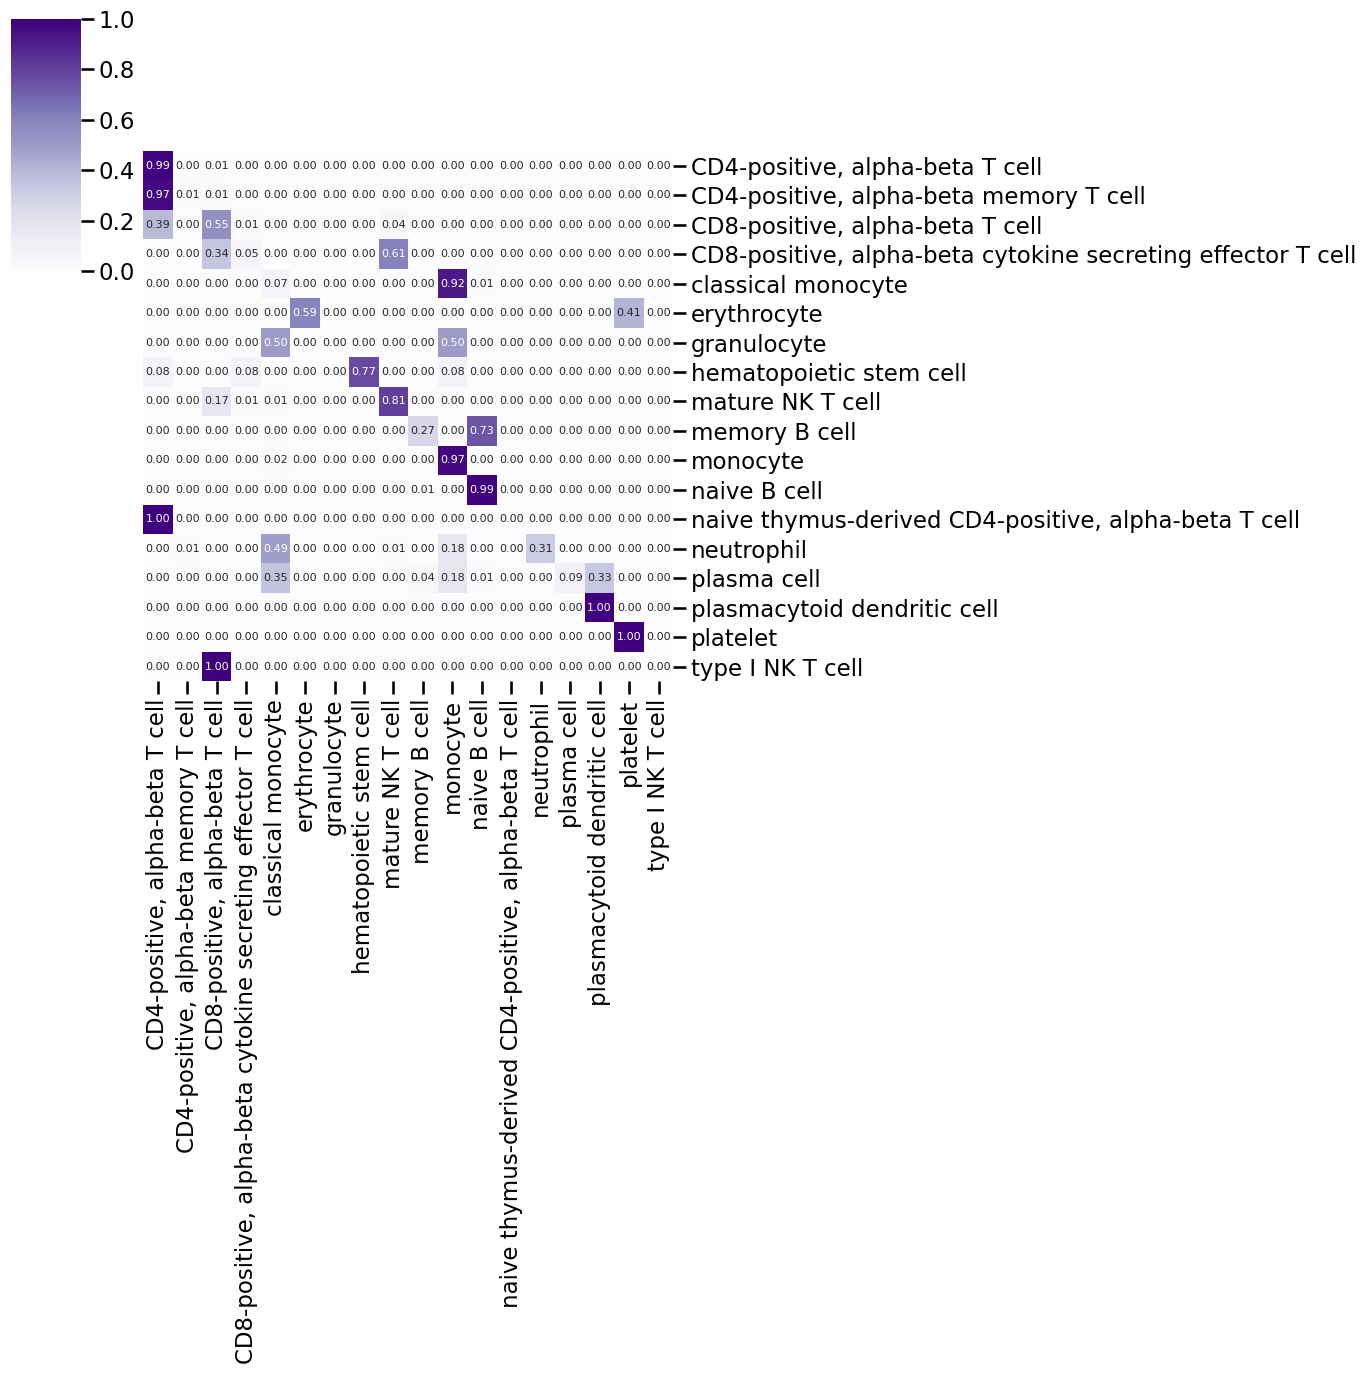

In [10]:
query_dict = compare_results(query_res[0], query_res[1], integration)
with open(f"../../results/{integration}_metrics.json", "w") as fp: 
    json.dump(query_dict, fp)

/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


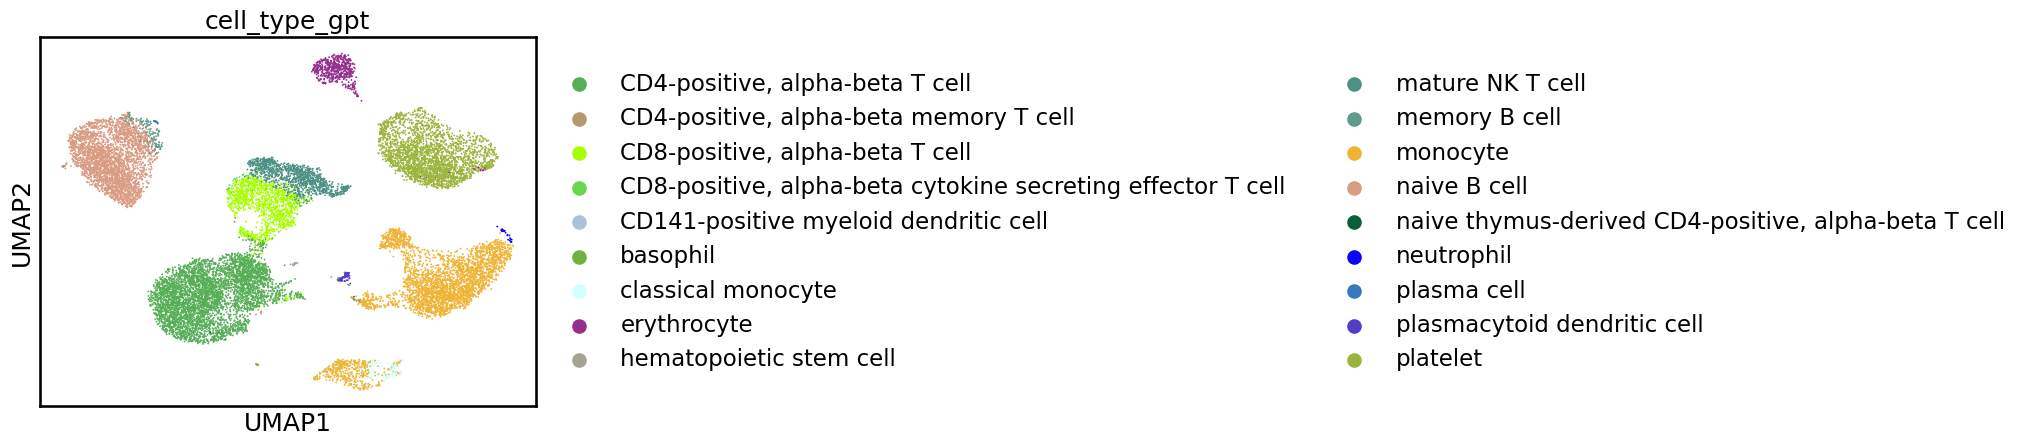

In [11]:
compute_umap(query_embed, rep="X_scGPT")
create_plots(query_embed, "cell_type_gpt", pal, f"{integration}_umap_gpt")

/home/jvfcavalcante/scratch/miniforge3/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


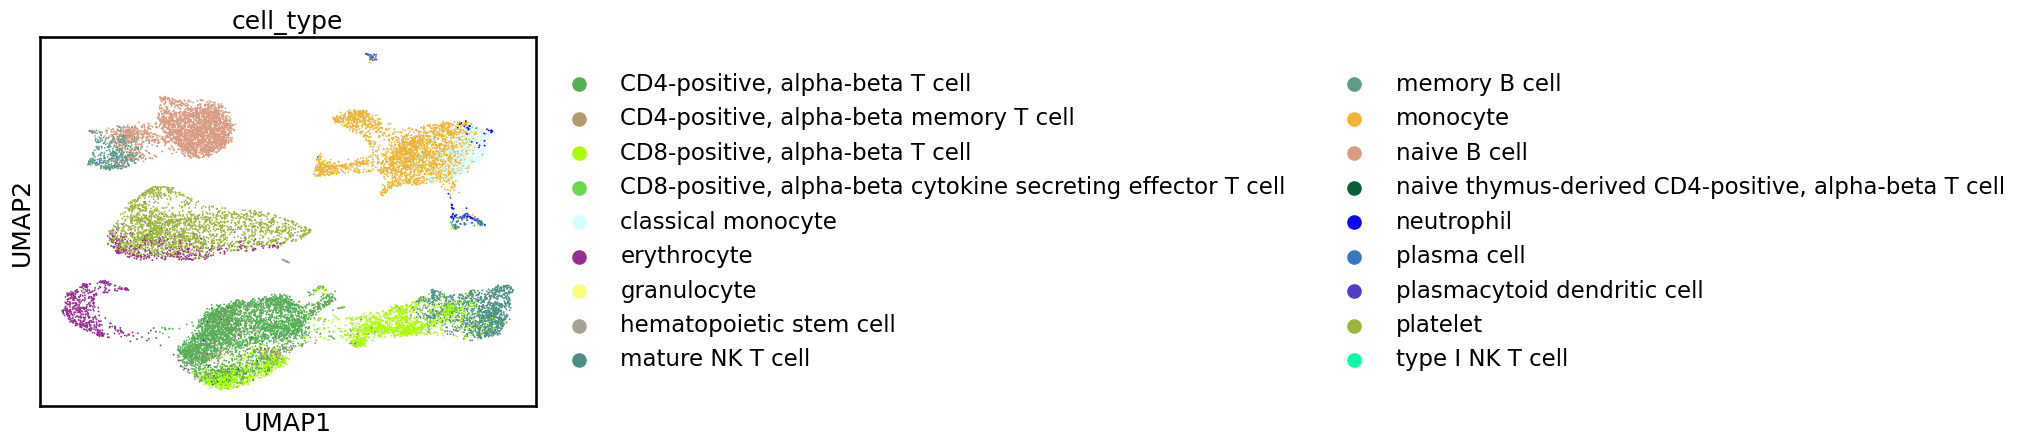

In [12]:
compute_umap(query_embed, rep=f"X_integrated.{integration}")
create_plots(query_embed, cell_type_key, pal, f"{integration}_umap_basic")